# Clasificador Neuronal para la detección del Glaucoma

### Páctica Deep Learning:                                                                                           Jorge Álvarez Gracia

*Ver Informe del estudio para más información

El proyecto se divide en varias partes diferenciadas: 

    -Librerías Utilizadas
    -Descarga del dataset y Carga para su uso
    -Settings
    -Funciones utilizadas
    -Sección 1: Análisis Exploratorio de los datos
    -Sección 2: Entrenamiento de una red neuronal sobre una única partición
    -Sección 3. Validación Cruza y discusión
    -Sección 4: Análisis crítico

------------------------------------------------------------------------------------------------------------------------------

### Liberías utilizadas

In [144]:
# imports:
import os
from zipfile import ZipFile
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
from PIL.ExifTags import TAGS
import numpy as np 
import pandas as pd 
import tensorflow as tf
import seaborn as sns
import keras
import sklearn.metrics as metrics
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0,EfficientNetB2, ResNet50, VGG16,EfficientNetB7
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Model
from tensorflow.keras.metrics import FalseNegatives, Accuracy
import tensorflow_addons as tfa 
import time
import timeit
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ProgbarLogger
from tensorflow.keras.callbacks import RemoteMonitor,TensorBoard
from tensorflow.keras.models import load_model
import random

### Descarga del dataset y Carga para su uso

Descargamos los archivos de kaggle

In [2]:
!pip3 install kaggle
# Download kaggle api token fillr ina  principal folder, for examle: C:\Users\Jorge\.kaggle 
# Download dataset
!kaggle datasets download -d jordidelatorreuoc/practica-dl-uoc-2022

You should consider upgrading via the 'C:\Users\Jorge\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.



  0%|          | 0.00/180M [00:00<?, ?B/s]
  2%|2         | 4.00M/180M [00:00<00:05, 33.3MB/s]
  6%|6         | 11.0M/180M [00:00<00:03, 54.3MB/s]
 11%|#         | 19.0M/180M [00:00<00:02, 64.0MB/s]
 15%|#5        | 27.0M/180M [00:00<00:02, 68.8MB/s]
 19%|#9        | 35.0M/180M [00:00<00:02, 71.3MB/s]
 24%|##3       | 43.0M/180M [00:00<00:01, 72.9MB/s]
 28%|##8       | 51.0M/180M [00:00<00:01, 74.0MB/s]
 33%|###2      | 59.0M/180M [00:00<00:01, 74.7MB/s]
 37%|###7      | 67.0M/180M [00:00<00:01, 75.2MB/s]
 42%|####1     | 75.0M/180M [00:01<00:01, 75.3MB/s]
 46%|####6     | 83.0M/180M [00:01<00:01, 75.8MB/s]
 51%|#####     | 91.0M/180M [00:01<00:01, 76.0MB/s]
 55%|#####5    | 99.0M/180M [00:01<00:01, 75.9MB/s]
 60%|#####9    | 107M/180M [00:01<00:01, 76.0MB/s] 
 64%|######4   | 115M/180M [00:01<00:00, 76.1MB/s]
 69%|######8   | 123M/180M [00:01<00:00, 76.1MB/s]
 73%|#######2  | 131M/180M [00:02<00:00, 52.5MB/s]
 77%|#######7  | 139M/180M [00:02<00:00, 57.9MB/s]
 82%|########1 | 147M/18

Extraemos el archivo .zip

In [17]:
local_zip = 'practica-dl-uoc-2022.zip'
# Extract all the contents of zip file in current directory
with ZipFile(local_zip, 'r') as zipObj:
    zipObj.extractall()

### Settings

In [145]:
# Sns plots configuration
sns.set_theme(style="whitegrid", palette="pastel")
sns.set_context("notebook", font_scale=1.2, rc={
                "lines.linewidth": 1.9, "axes.spines.right": False, "axes.spines.top": False})

In [146]:
BASE_DIR = 'practica_DL_UOC_2022'
N_CLASSES = 2
CLASS_NAMES = ['normal','abnormal']
BATCH_SIZE = 32  # Ver documento
IMG_SIZE = (224, 224)
SHAPE = (224, 224, 3)
SEED = 1234
MODEL_PATH ='models/'
SAVE_MODEL_PATH = '/saved_model'
MODEL_FINAL_NAME = 'model_final'
MODEL_FILETYPE = '.h5'
CSV_FINAL_NAME = '/Evaluated_final_metrics.csv'
N_MODELS = 5
DROUP_RATE = 0.20 # fixed
OPTIMIZER = Adam
LR = 1e-4 #
EPOCHS = 100
LEARNING_RATES = [1e-4, 3e-4, 5e-4, 0.001, 0.01]
#OPTIMIZERS = [Adam, SGD] Adam
BATCH_SIZES = [32,64]  # Ver documento
BEST_LR = 0.0005 # Added later
BEST_BATCH = 32 # Added later
N_FOLDS = 10

### Funciones utilizadas 

In [194]:
def open_examinate_fold(fold_number, base_dir=BASE_DIR):
    
    """ Examines the directories and files obtaining information about them 
    and returns this information and lists of the different directories """

    fold = 'Fold' + str(fold_number)
    fold_dir = os.path.join(base_dir, fold)
    train_dir = os.path.join(fold_dir, 'train')
    validation_dir = os.path.join(fold_dir, 'valid')
    test_dir = os.path.join(fold_dir, 'test')

    # Directorio con las imagenes de training
    train_normal_dir = os.path.join(train_dir, 'normal')
    train_abnormal_dir = os.path.join(train_dir, 'abnormal')

    # Directorio con las imagenes de validation
    validation_normal_dir = os.path.join(validation_dir, 'normal')
    validation_abnormal_dir = os.path.join(validation_dir, 'abnormal')

    # Directorio con las imagenes de test
    test_normal_dir = os.path.join(test_dir, 'normal')
    test_abnormal_dir = os.path.join(test_dir, 'abnormal')

    primary_dir_list = [train_dir, validation_dir, test_dir]

    dir_list = [train_normal_dir, train_abnormal_dir,
                validation_normal_dir, validation_abnormal_dir,
                test_normal_dir, test_abnormal_dir]

    data_info = {'Fold_name': [], 'Train_normal': [], 'Train_abnormal': [], 'Validation_normal': [],
                 'Validation_abnormal': [], 'Test_normal': [], 'Test_abnormal': [], 'Total_normal': [], 'Total_abnormal': []}

    data_info['Fold_name'].append(fold)
    data_info['Train_normal'].append(len(os.listdir(dir_list[0])))
    data_info['Train_abnormal'].append(len(os.listdir(dir_list[1])))
    data_info['Validation_normal'].append(len(os.listdir(dir_list[2])))
    data_info['Validation_abnormal'].append(len(os.listdir(dir_list[3])))
    data_info['Test_normal'].append(len(os.listdir(dir_list[4])))
    data_info['Test_abnormal'].append(len(os.listdir(dir_list[5])))
    data_info['Total_normal'].append((len(os.listdir(dir_list[0])))
                                     + (len(os.listdir(dir_list[2])))
                                     + (len(os.listdir(dir_list[4]))))
    data_info['Total_abnormal'].append((len(os.listdir(dir_list[1])))
                                       + (len(os.listdir(dir_list[3])))
                                       + (len(os.listdir(dir_list[5]))))
    data_info_df = pd.DataFrame(data_info)

    return primary_dir_list, dir_list, data_info_df

In [195]:
def display_pictures(dire):
    
    """ Shows different images of normal and abnormal gloucoma """
    
    file_names = os.listdir(dire)

    nrows = 4
    ncols = 4

    pic_index = 0

    fig = plt.gcf()
    fig.set_size_inches(ncols*4, nrows*4)

    pic_index += 8

    next_pix = [os.path.join(str(dire), fname)
                for fname in file_names[pic_index-8:pic_index]]

    for i, img_path in enumerate(next_pix):
        sp = plt.subplot(nrows, ncols, i + 1)
        img = mpimg.imread(img_path)
        plt.imshow(img)

    plt.show()

In [196]:
def create_directories(model_path, model_final_name, n_models):
    
    """ Create directories of the different models"""
    
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    model_final_path = model_path + model_final_name

    models_list_path = []
    for i in range(1, n_models+1):
        model_name = 'model_' + str(i)
        model_save_path = model_path + model_name
        models_list_path.append(model_save_path)
        if not os.path.exists(model_save_path):
            os.makedirs(model_save_path)

    if not os.path.exists(model_final_path):
        os.makedirs(model_final_path)
    models_list_path.append(model_final_path)

    return models_list_path

In [197]:
# Create models folders
def create_final_model_directories(model_final_path):
    
    """ Create final model directories """
    
    models_by_fold_list_path = []
    for i in range(0, N_FOLDS):
        fold_path_name = '/Results_Fold_' + str(i)
        final_model__path = model_final_path + fold_path_name
        models_by_fold_list_path.append(final_model__path)
        if not os.path.exists(final_model__path):
            os.makedirs(final_model__path)

    return models_by_fold_list_path

In [198]:
def build_image_generator(fold_number, shape=SHAPE, img_size=IMG_SIZE):


    """ Data argumentation and load images from the directories """
    # Data argumentation (training):
    print(
        f'[INFO]: Data argumentation & Image Generator] : Fold number: {fold_number}, Shape:{shape}, Image Size:{img_size}')

    train_datagen = ImageDataGenerator(
        rotation_range=20,  # Change
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode='nearest')

    primary_dir_list, dir_list_fold, data_info_df_fold = open_examinate_fold(
        fold_number)

    train_dir, validation_dir, test_dir = primary_dir_list

    # Training generator:

    train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                        classes=CLASS_NAMES,
                                                        class_mode='categorical',
                                                        target_size=(
                                                            (img_size)), color_mode='rgb',
                                                        shuffle=True, seed=SEED)

    print('[INFO]: Training Data Generator:...............OK')

    # Validation generator:

    validation_generator = ImageDataGenerator().flow_from_directory(directory=validation_dir,
                                                                    classes=CLASS_NAMES,
                                                                    class_mode='categorical',
                                                                    target_size=(
                                                                        img_size), color_mode='rgb',
                                                                    shuffle=False, seed=SEED)

    print('[INFO]: Validation Data Generator:...............OK')

    # Test generator:

    test_generator = ImageDataGenerator().flow_from_directory(directory=test_dir,
                                                              classes=CLASS_NAMES,
                                                              class_mode='categorical',
                                                              target_size=(
                                                                  img_size), color_mode='rgb',
                                                              shuffle=False)

    print('[INFO]: Test Data Generator:...............OK')

    return train_generator, validation_generator, test_generator

In [199]:
def model_callbacks(save_path, reduceLr=True,
                    checkPoint=True, csvlogger=True, earlyStopping=True,
                    progbar=True, remotemonitor=True, tensorboard=True):
    """ Differents Callbacks for the models  """

    callbacks = []
    filename = os.path.join(save_path, 'CSVLogger.csv')

    # Reduce learning rate when a metric has stopped improving.
    if reduceLr == True:
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=10,
            verbose=0,
            mode='auto',
            min_delta=0.0001,
            cooldown=0,
            min_lr=0)

        callbacks.append(reduce_lr)

    if checkPoint == True:
        # Callback to save the Keras model or model weights at some frequency.
        checkpoint = ModelCheckpoint(
            save_path,
            monitor='val_loss',
            verbose=0,
            save_best_only=True,
            save_weights_only=False,
            mode='auto',
            save_freq='epoch',
            options=None,
            initial_value_threshold=None)

        callbacks.append(checkpoint)

    if csvlogger == True:

        csvLogger = CSVLogger(filename,
                              separator=',', append=False)
        callbacks.append(csvLogger)

    if earlyStopping == True:
        # Stop training when a monitored metric has stopped improving.
        early_stopping = EarlyStopping(
            monitor='val_loss',
            min_delta=10,
            patience=15,
            verbose=2,
            mode='auto',
            baseline=None,
            restore_best_weights=False)

        callbacks.append(early_stopping)

    if progbar == True:
        # Callback that prints metrics to stdout.
        progbarlogger = ProgbarLogger(
            count_mode='steps', stateful_metrics=['acc']
        )
        callbacks.append(progbarlogger)

    if remotemonitor == True:
        # Callback used to stream events to a server.
        remote_monitor = RemoteMonitor(
            root='http://localhost:9000',
            path='/publish/epoch/end/',
            field='data',
            headers=None,
            send_as_json=False
        )
        callbacks.append(remote_monitor)

    if tensorboard == True:
        run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")

        model_save_logs = os.path.join(save_path, 'my_logs')
        if not os.path.exists(model_save_logs):
            os.makedirs(model_save_logs)
        run_logdir = os.path.join(model_save_logs, run_id)

        # Callback used to stream events to a server.
        tensorBoard = TensorBoard(
            log_dir=run_logdir,
            histogram_freq=0,
            write_graph=True,
            write_images=False,
            write_steps_per_second=False,
            update_freq='epoch',
            profile_batch=0,
            embeddings_freq=0,
            embeddings_metadata=None,

        )
        callbacks.append(tensorBoard)

    return callbacks

In [200]:
def model_lr_batch(n_classes, shape, epochs, batch_sizes, learning_rates, dropout_rate=0.20):
    """ Create, compile, train and find the best hyperparameters for model 1"""
    tf.random.set_seed(42)

    metrics = {'Batch': [], 'Learning rate': [],
               'Time': [], 'F1_Score': [], 'Loss': []}
    hist = []
    models = []

    inputs = layers.Input(shape=shape, name='input_layer')

    # Get base model
    base_model = EfficientNetB0(include_top=False, weights='imagenet')

    # Freeze weights
    base_model.trainable = False
    x = base_model(inputs, training=False)

    # Rebuild top
    x = GlobalAveragePooling2D(name='avg_pool')(x)
    x = BatchNormalization(name='batch_norm')(x)

    x = layers.Dropout(dropout_rate, name='top_dropout')(x)
    outputs = layers.Dense(
        n_classes, activation='softmax', name='activationLayer')(x)

    for batch_size in batch_sizes:
        for lr in learning_rates:
            # Compile
            f1 = tfa.metrics.F1Score(n_classes, 'macro')
            model = Model(inputs, outputs, name='EfficientNetB0_G')
            model.compile(loss='categorical_crossentropy',
                          optimizer=Adam(learning_rate=lr), metrics=[f1])

            # Fit
            start_time = timeit.default_timer()
            history = model.fit(x=train_generator,
                                steps_per_epoch=train // batch_size,
                                validation_data=validation_generator,
                                validation_steps=validation // batch_size,
                                epochs=EPOCHS,
                                verbose=0, callbacks=callbacks
                                )

            timeDif = timeit.default_timer() - start_time
            hist.append(history)
            models.append(model)
            metrics['Batch'].append(batch_size)
            metrics['Learning rate'].append(lr)

            # Evaluate
            metrics['F1_Score'].append(
                model.evaluate(test_generator, verbose=2)[1])
            metrics['Loss'].append(model.evaluate(
                test_generator, verbose=0)[0])
            metrics['Time'].append(timeDif)
            print(
                f' Model with optimizer Adam , batch size: {batch_size} and learning rate: {lr} is evaluating.....ok')
    metrics_df = pd.DataFrame(metrics)

    return hist, models, metrics_df

In [201]:
def saving_model(model_path, model):
    
    """Save the model """
    
    model_save_path = model_path + SAVE_MODEL_PATH + MODEL_FILETYPE
    model.save(model_save_path)

In [202]:
def f1_loss_plot(history, model_path):
    
    """Create, display and save plots of metrics, epochs and loss """

    plt.plot(history.history['f1_score'])
    plt.plot(history.history['val_f1_score'])
    plt.title('Model f1_score')
    plt.ylabel('f1_score')
    plt.xlabel('Epoch')
    plt.legend(['Train_val', 'Val_val'], loc='upper left')
    plt.savefig(os.path.join(model_path, '1_.f1_score_vs_val_f1_score.png'))
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train_loss', 'Val_loss'], loc='upper left')
    plt.savefig(os.path.join(model_path, '2_.loss_vs_val_loss.png'))
    plt.show()

In [205]:
def create_confusion_matrix_other_metrics(test_y, model, class_names, model_path):
    
    """Create, display and saveCreate the confusion matrix and f1 score"""

    pred_y = model.predict(test_y).argmax(axis=1)
    cm = metrics.confusion_matrix(test_y.classes, pred_y)

    df_cm = pd.DataFrame(cm, index=[i for i in class_names], columns=[
                         i for i in class_names])
    fig, ax = plt.subplots(figsize=(8, 6))
    ax = sns.heatmap(df_cm, annot=True, cmap="Reds", fmt='.2g', alpha=0.7)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    plt.title('Confussion Matrix', fontsize=17)
    plt.savefig(os.path.join(model_path, '3_.Confussion_Matrix.png'))
    plt.show()

    clfr = metrics.classification_report(
        test_y.classes, pred_y, digits=3, target_names=class_names, output_dict=True)
    clfr_df = pd.DataFrame(clfr).iloc[:-1, :-3].T
    fig, ax = plt.subplots(figsize=(8, 6))
    ax = sns.heatmap(clfr_df, annot=True, cmap="Reds", fmt='.2g', alpha=0.7)
    plt.title('Precison & Recall & F1-Score', fontsize=17)
    plt.savefig(os.path.join(
        model_path, '4_.Precison_&_Recall_&_F1-Score.png'))
    plt.show()

In [208]:
def build_model_unfreeze_20(model, n_classes, shape, lr, ufl, dropout_rate=0.2):
    
    """ Create model 1 with 20 unfreeze layers"""
    
    tf.random.set_seed(42)

    eb0_layer = model.get_layer(name='efficientnetb0')

   # Unfreeze last 20 layers
    for layer in eb0_layer.layers[len(eb0_layer.layers)-ufl:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

        # Compile
    f1 = tfa.metrics.F1Score(n_classes, 'macro')
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=lr), metrics=[f1])

    return model

In [209]:
def train_evaluate_model(model, model_path, fold, batch):
    
    """Train, evaluate and save models"""
    
    tf.random.set_seed(42)

    train_generator, validation_generator, test_generator = build_image_generator(
        fold)
    train = train_generator.samples
    validation = validation_generator.samples
    test = test_generator.samples

    start_time = timeit.default_timer()
    history = model.fit(x=train_generator,
                        steps_per_epoch=train // int(batch),
                        validation_data=validation_generator,
                        validation_steps=validation // int(batch),
                        epochs=EPOCHS,
                        verbose=0, callbacks=callbacks
                        )

    timeDif = timeit.default_timer() - start_time
    print('[INFO]: Model training ............... OK')
    print('[INFO]: Execution time: ', timeDif)
    scores = model.evaluate(test_generator)
    print(
        f'[INFO]: Model evaluating....loss: {scores[0]}, F1 score: {scores[1]}....OK')
    f1_loss_plot(history, models_list_path[model_path])
    print('[INFO]: Saving plots.............. OK ')
    create_confusion_matrix_other_metrics(
        test_generator, model, CLASS_NAMES, models_list_path[model_path])
    print('[INFO]: Saving confusion matrix and other metrics............OK')
    saving_model(models_list_path[model_path], model)
    print('[INFO]: Saving model.............OK')

    return model



In [210]:
def model_vgg16(n_classes, shape, epochs, lr=3e-4, dropout_rate=0.30):
    
    """ Create model 4 with 20 unfreeze layers"""
    
    tf.random.set_seed(42)

    inputs = layers.Input(shape=shape, name='input_layer')

    # Get base model
    base_model = VGG16(include_top=False, weights='imagenet')

    # Freeze weights
    base_model.trainable = False
    x = base_model(inputs, training=False)

    # Rebuild top
    x = GlobalAveragePooling2D(name='avg_pool')(x)
    x = BatchNormalization(name='batch_norm')(x)
    x = layers.Dropout(dropout_rate, name='top_dropout')(x)
    outputs = layers.Dense(
        n_classes, activation='softmax', name='activationLayer')(x)

    model = Model(inputs, outputs, name=' model_vgg16')

    model.trainable = True
    
    
    vgg_layer = model.get_layer(name = 'vgg16')

   # Unfreeze last 20 layers
    for layer in vgg_layer.layers[len(vgg_layer.layers)-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = False
            

        # Compile
    f1 = tfa.metrics.F1Score(n_classes, 'macro')
    model = Model(inputs, outputs, name='vgg16_Gloucoma')
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=lr), metrics=[f1])

    return model

In [211]:

def model_EfficientNetB2(n_classes, shape, epochs, lr=BEST_LR, dropout_rate=0.20):
    """ Create model 5 with 20 unfreeze layers"""
    tf.random.set_seed(42)

    inputs = layers.Input(shape=shape, name='input_layer')

    # Get base model
    base_model = EfficientNetB2(include_top=False, weights='imagenet')

    # Freeze weights
    base_model.trainable = False
    x = base_model(inputs, training=False)

    # Rebuild top
    x = GlobalAveragePooling2D(name='avg_pool')(x)
    x = BatchNormalization(name='batch_norm')(x)
    x = layers.Dropout(dropout_rate, name='top_dropout')(x)
    outputs = layers.Dense(
        n_classes, activation='softmax', name='activationLayer')(x)

    model = Model(inputs, outputs, name=' model_EfficientNetB')

    model.trainable = True
    
    
    efficientnetb4_layer = model.get_layer(name = 'efficientnetb2')

   # Unfreeze last 20 layers
    for layer in efficientnetb4_layer.layers[len(efficientnetb4_layer.layers)-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = False
            

        # Compile
        
    f1 = tfa.metrics.F1Score(n_classes, 'macro')
    model = Model(inputs, outputs, name='EfficientNetB2_Gloucoma')
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=lr), metrics=[f1])

    return model

## Sección 1:  Análisis Exploratorio de los datos

In [161]:
data_info_df_final = []
number_of_fold = len(next(os.walk(BASE_DIR))[1])
dir_list_total = []

for i in range(0, number_of_fold):

    primary_dir_list, dir_list_fold, data_info_df_fold = open_examinate_fold(i)
    dir_list_total.append(dir_list_fold)

    data_info_df_final.append(data_info_df_fold)

data_info_df_final = pd.concat(data_info_df_final).reset_index(drop=True)
print('-------------------------Information about directories, files and folds-----------------------')
print('Directories for a x fold:', dir_list_total[0])
display(data_info_df_final)

-------------------------Information about directories, files and folds-----------------------
Directories for a x fold: ['practica_DL_UOC_2022\\Fold0\\train\\normal', 'practica_DL_UOC_2022\\Fold0\\train\\abnormal', 'practica_DL_UOC_2022\\Fold0\\valid\\normal', 'practica_DL_UOC_2022\\Fold0\\valid\\abnormal', 'practica_DL_UOC_2022\\Fold0\\test\\normal', 'practica_DL_UOC_2022\\Fold0\\test\\abnormal']


,Fold_name,Train_normal,Train_abnormal,Validation_normal,Validation_abnormal,Test_normal,Test_abnormal,Total_normal,Total_abnormal
0,Fold0,754,625,83,71,82,92,919,788
1,Fold1,740,639,88,66,91,83,919,788
2,Fold2,739,640,83,71,97,77,919,788
3,Fold3,743,636,85,69,91,83,919,788
4,Fold4,746,633,81,73,92,82,919,788
5,Fold5,758,621,71,83,90,84,919,788
6,Fold6,754,625,84,70,81,93,919,788
7,Fold7,737,642,82,72,100,74,919,788
8,Fold8,748,631,80,74,91,83,919,788
9,Fold9,733,646,82,72,104,70,919,788


### Visualizaciones de imagenes

Visualizamos por ejemplo del fold 0 y del set de training diferentes imagenes con glaucoma normal y abnormal

Images of the fold 0 , training set and normal glaucoma:


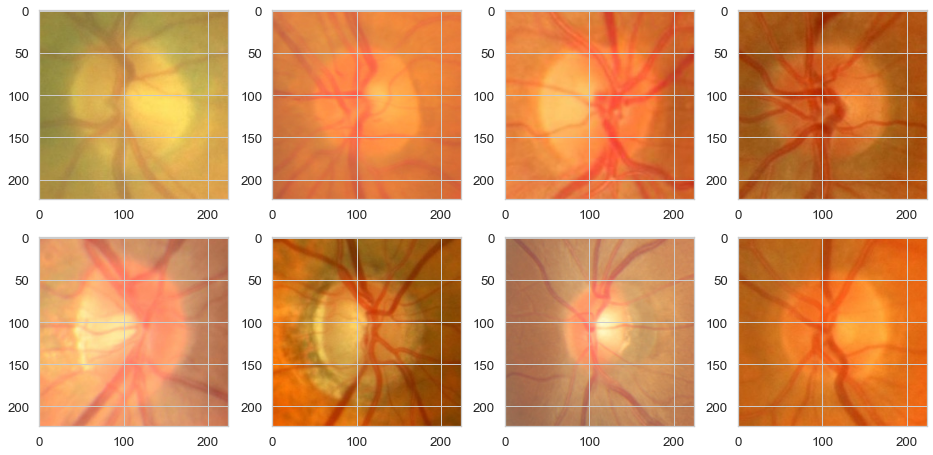

Images of the fold 0 , training set and abnormal glaucoma:


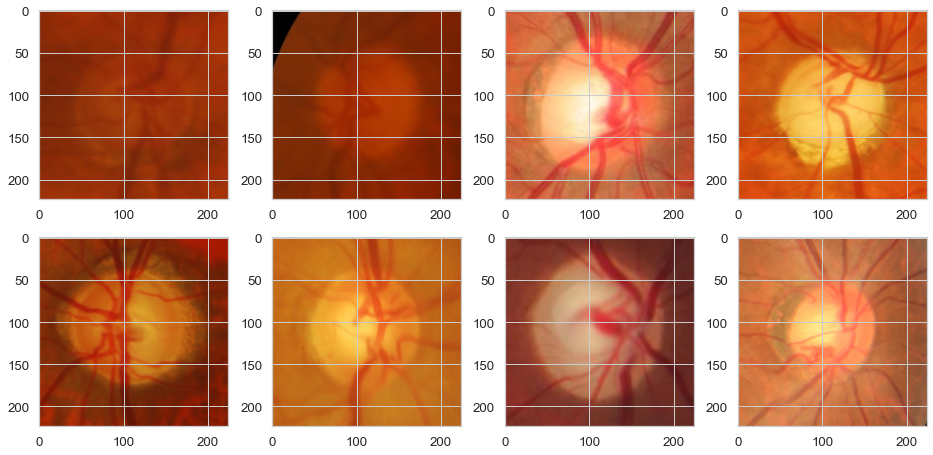

In [162]:
print('Images of the fold 0 , training set and normal glaucoma:')
display_pictures(dir_list_total[0][0])
print('Images of the fold 0 , training set and abnormal glaucoma:')
display_pictures(dir_list_total[0][1])

### Image metadata

In [163]:
train_normal_image_names = os.listdir(dir_list_total[0][0])
dir_list_total[0][1]

path = os.path.join(dir_list_total[0][0], train_normal_image_names[0])
image = Image.open(path)
print('[INFO]: Image Features:', image)

[INFO]: Image Features: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x1854D9F9930>


### Creamos las carpetas de los diferentes modelos a estudiar

In [164]:
models_list_path = create_directories(MODEL_PATH, MODEL_FINAL_NAME,N_MODELS)
print(f'[INFO]: Create model list path:.........{models_list_path}........OK ')

[INFO]: Create model list path:.........['models/model_1', 'models/model_2', 'models/model_3', 'models/model_4', 'models/model_5', 'models/model_final']........OK 


### Data argumentation & Image data generator

En un primer momento solo realizamos este proceso para el fold0

In [165]:
train_generator, validation_generator, test_generator = build_image_generator(0)

[INFO]: Data argumentation & Image Generator] : Fold number: 0, Shape:(224, 224, 3), Image Size:(224, 224)
Found 1379 images belonging to 2 classes.
[INFO]: Training Data Generator:...............OK
Found 154 images belonging to 2 classes.
[INFO]: Validation Data Generator:...............OK
Found 174 images belonging to 2 classes.
[INFO]: Test Data Generator:...............OK


## Sección 2:  Entramiento de una red neuronal sobre una única partición

### 1) Modelo 1: EfficientNet B0
#### Preentrenado con pesos de Imagenet, modelo congelado excepto para capas superiores y añadiendo una capa Global Average Polling 2D, capa BatchNormalization y capa fully connected

In [214]:
train = train_generator.samples
validation = validation_generator.samples
test = test_generator.samples

### A) Buscamos los mejores hiperparámetros

In [215]:
callbacks = model_callbacks(
    models_list_path[0], reduceLr=False,
    checkPoint=False, csvlogger=False,
    earlyStopping=True, progbar=False,
    remotemonitor=False, tensorboard=False )

print('[INFO]: Callbacks Activate: ', callbacks)

[INFO]: Callbacks Activate:  [<keras.callbacks.EarlyStopping object at 0x00000183D8168730>]


En primer lugar, buscaremos los parámetros más eficientes en referencia al batch y al learning rate, el optimizador elegido es Adam y el enunciado expone que tenemos que usar f1 como métrica principal.
Elegiremos aquellos parámetros que minimicen el error en la evaluación del modelo con el conjunto de datos de prueba y después de su entrenamiento.

In [216]:
hist, mod, metrics_df = model_lr_batch(N_CLASSES, SHAPE, EPOCHS, BATCH_SIZES, LEARNING_RATES)

Epoch 16: early stopping
6/6 - 0s - loss: 0.5095 - f1_score: 0.7742 - 301ms/epoch - 50ms/step
 Model with optimizer Adam , batch size: 32 and learning rate: 0.0001 is evaluating.....ok
Epoch 16: early stopping
6/6 - 0s - loss: 0.4672 - f1_score: 0.8081 - 387ms/epoch - 64ms/step
 Model with optimizer Adam , batch size: 32 and learning rate: 0.0003 is evaluating.....ok
Epoch 16: early stopping
6/6 - 0s - loss: 0.5249 - f1_score: 0.7964 - 316ms/epoch - 53ms/step
 Model with optimizer Adam , batch size: 32 and learning rate: 0.0005 is evaluating.....ok
Epoch 16: early stopping
6/6 - 0s - loss: 0.4831 - f1_score: 0.8317 - 310ms/epoch - 52ms/step
 Model with optimizer Adam , batch size: 32 and learning rate: 0.001 is evaluating.....ok
Epoch 16: early stopping
6/6 - 0s - loss: 0.9462 - f1_score: 0.7802 - 302ms/epoch - 50ms/step
 Model with optimizer Adam , batch size: 32 and learning rate: 0.01 is evaluating.....ok
Epoch 16: early stopping
6/6 - 0s - loss: 0.9719 - f1_score: 0.7959 - 388ms/ep

In [219]:
print('[INFO:] The best model is :\n{}'.format((metrics_df.sort_values(by = ['Loss'] , ascending=True)[0:1])))
model_1_best_paramters = metrics_df.sort_values(by = ['Loss'] , ascending=True)
model_1_best_paramters.to_csv(os.path.join(models_list_path[0],'best_parameters.csv'))
display(model_1_best_paramters)
print('[INFO:] This information has been saved in a csv')

[INFO:] The best model is :
   Batch  Learning rate       Time  F1_Score      Loss
1     32         0.0003  178.58153  0.808056  0.467157


,Batch,Learning rate,Time,F1_Score,Loss
1,32,0.0003,178.581530,0.808056,0.467157
3,32,0.0010,181.465037,0.831727,0.483064
0,32,0.0001,177.634881,0.774184,0.509532
2,32,0.0005,176.924943,0.796423,0.524928
8,64,0.0010,89.319415,0.826116,0.730417
7,64,0.0005,90.115609,0.820122,0.801634
6,64,0.0003,90.609430,0.801982,0.885984
4,32,0.0100,178.987493,0.780186,0.946190
5,64,0.0001,89.328023,0.795877,0.971947
9,64,0.0100,89.953086,0.705054,1.367804


[INFO:] This information has been saved in a csv


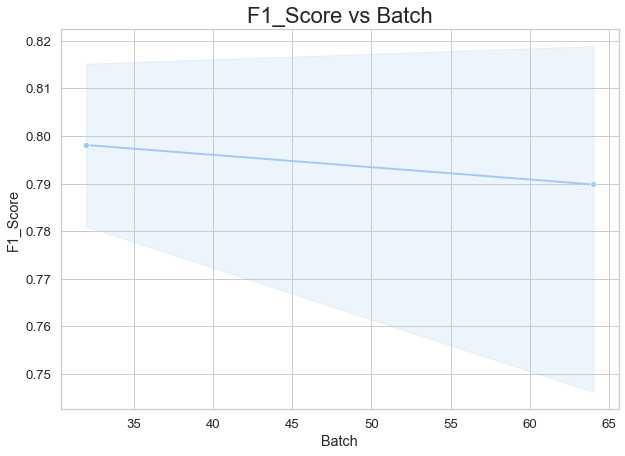

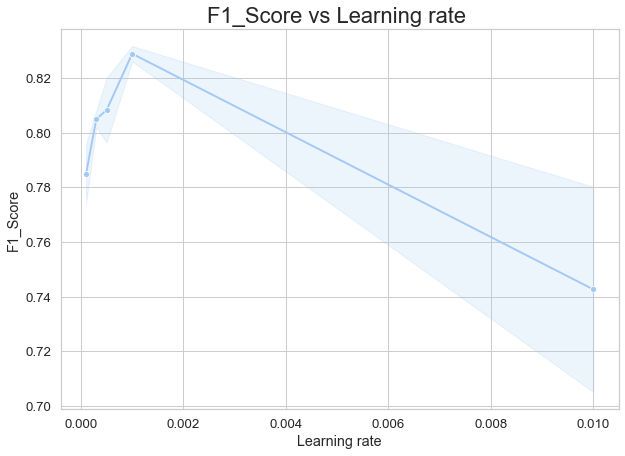

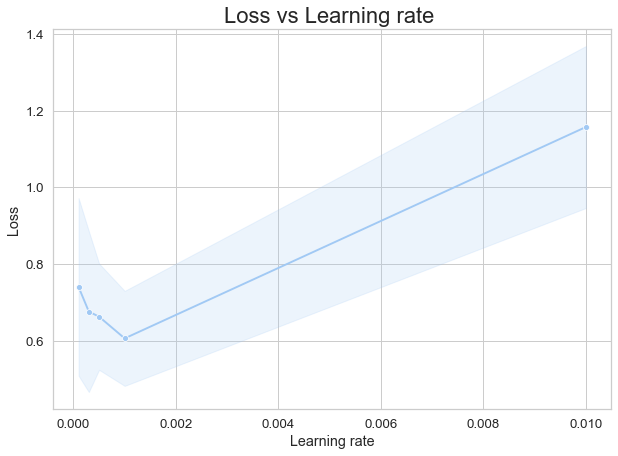

In [220]:
plt.figure(figsize=(10, 7))
ax = sns.lineplot(y="F1_Score", x="Batch",
                  marker='o',
                  data=metrics_df)
ax.set_title('F1_Score vs Batch', fontsize=22)
plt.savefig(os.path.join(models_list_path[0], '0._model_1_lr_vs_Batch.png'))


plt.figure(figsize=(10, 7))
ax = sns.lineplot(x="Learning rate", y="F1_Score",
                  marker='o',
                  data=metrics_df)
ax.set_title('F1_Score vs Learning rate ', fontsize=22)
plt.savefig(os.path.join(models_list_path[0], '0._model_1_lr_vs_F1_SCORE.png'))

plt.figure(figsize=(10, 7))
ax = sns.lineplot(x="Learning rate", y="Loss",
                  marker='o',
                  data=metrics_df)
ax.set_title('Loss vs Learning rate ', fontsize=22)
plt.savefig(os.path.join(models_list_path[0], '0._model_1_lr_vs_Loss.png'))
plt.show()

In [221]:
metrics_df_c = (metrics_df.sort_values(by = ['Loss'] , ascending=True))
best_batch = [metrics_df_c.iloc[0,0]]
best_lr = [metrics_df_c.iloc[0,1]]
print('[INFO:] Best Learning rate is:', best_lr)
print('[INFO:] Best batch rate is:', best_batch)

[INFO:] Best Learning rate is: [0.0003]
[INFO:] Best batch rate is: [32]


A pesar que en este caso nuestro mejor learning rate se el 0.0003 hemos demostrado que para el resto de los modelos y para ciertas ejecuciones, el mejor sería: 0.0005

In [222]:
best_batch = [BEST_BATCH]
best_lr = [BEST_LR]

### B) Entrenamos el modelo con los mejores parámetros

In [175]:
callbacks = model_callbacks(
    models_list_path[0], reduceLr=False,
    checkPoint=True, csvlogger=True,
    earlyStopping=True, progbar=False,
    remotemonitor=False, tensorboard=False )

print('Callbacks Activate: ', callbacks)

Callbacks Activate:  [<keras.callbacks.ModelCheckpoint object at 0x00000184C4153C70>, <keras.callbacks.CSVLogger object at 0x00000184C4151840>, <keras.callbacks.EarlyStopping object at 0x00000184C4153B80>]


In [176]:
histBestModel, modBestModel, metricsBestModel =  model_lr_batch(N_CLASSES, SHAPE, EPOCHS, best_batch, best_lr)

INFO:tensorflow:Assets written to: models\model_1\assets
INFO:tensorflow:Assets written to: models\model_1\assets
INFO:tensorflow:Assets written to: models\model_1\assets
INFO:tensorflow:Assets written to: models\model_1\assets
INFO:tensorflow:Assets written to: models\model_1\assets
INFO:tensorflow:Assets written to: models\model_1\assets
INFO:tensorflow:Assets written to: models\model_1\assets
INFO:tensorflow:Assets written to: models\model_1\assets
INFO:tensorflow:Assets written to: models\model_1\assets
INFO:tensorflow:Assets written to: models\model_1\assets
INFO:tensorflow:Assets written to: models\model_1\assets
INFO:tensorflow:Assets written to: models\model_1\assets
Epoch 16: early stopping
6/6 - 0s - loss: 0.4767 - f1_score: 0.7909 - 299ms/epoch - 50ms/step
 Model with optimizer Adam , batch size: 32 and learning rate: 0.0005 is evaluating.....ok


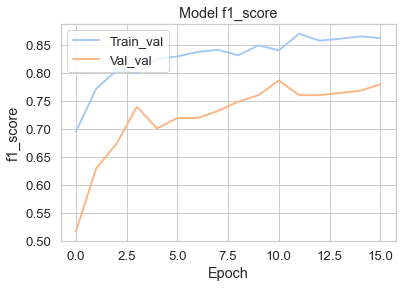

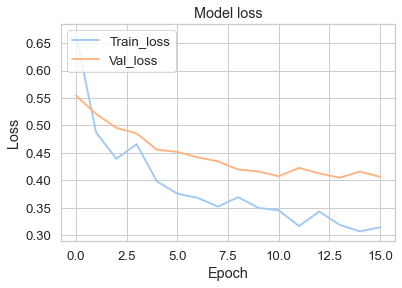

In [212]:
f1_loss_plot(histBestModel[0],models_list_path[0])

6/6 [==============================] - 1s 42ms/step - loss: 0.4767 - f1_score: 0.7909
[0.4767242968082428, 0.7908653020858765]
[INFO]: The model has a evaluate f1 score of: 0.7908653020858765


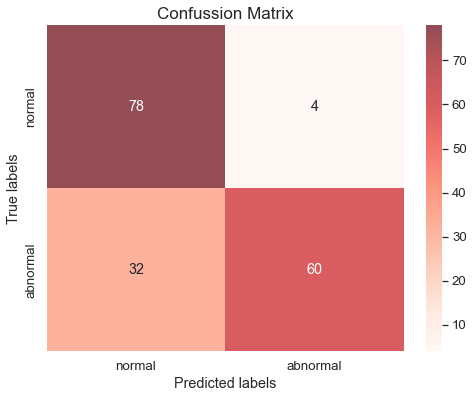

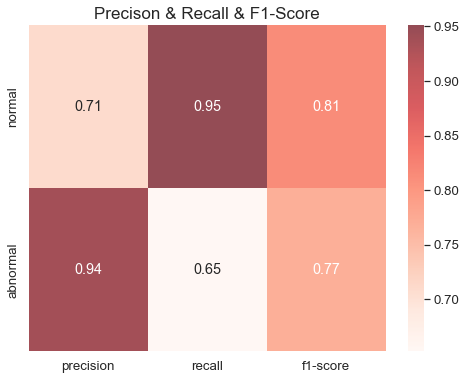

In [213]:
scores = modBestModel[0].evaluate(test_generator)
print(scores)
print('[INFO]: The model has a evaluate f1 score of: {}'.format(scores[1]))

create_confusion_matrix_other_metrics(test_generator, modBestModel[0], CLASS_NAMES, models_list_path[0])

In [125]:
saving_model(models_list_path[0] , modBestModel[0])

### 2) Modelo 2: EfficientNet B0
#### Con los parámetros elegidos, descongelamos las últimas 20 capas del modelo 1 pero dejando BatchNorm sin descongelar

Cargamos el modelo 1:

In [126]:
model_load_path_1 = models_list_path[0]+ SAVE_MODEL_PATH + MODEL_FILETYPE
model_1 = load_model(model_load_path_1)

In [127]:
model_2 = build_model_unfreeze_20(model_1,N_CLASSES, SHAPE, BEST_LR, 20) #best 
model_2.summary()

Model: "EfficientNetB0_G"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 avg_pool (GlobalAveragePool  (None, 1280)             0         
 ing2D)                                                          
                                                                 
 batch_norm (BatchNormalizat  (None, 1280)             5120      
 ion)                                                            
                                                                 
 top_dropout (Dropout)       (None, 1280)              0         
                                                                 
 activationLayer (Dense)     (None, 2)            

In [128]:
callbacks = model_callbacks(
    models_list_path[1], reduceLr=False,
    checkPoint=True, csvlogger=True,
    earlyStopping=True, progbar=False,
    remotemonitor=False, tensorboard=False)

print('[INFO]: Callbacks Activate: ', callbacks)

[INFO]: Callbacks Activate:  [<keras.callbacks.ModelCheckpoint object at 0x0000018482D12DA0>, <keras.callbacks.CSVLogger object at 0x0000018482D135B0>, <keras.callbacks.EarlyStopping object at 0x00000184548305E0>]


[INFO]: Data argumentation & Image Generator] : Fold number: 0, Shape:(224, 224, 3), Image Size:(224, 224)
Found 1379 images belonging to 2 classes.
[INFO]: Training Data Generator:...............OK
Found 154 images belonging to 2 classes.
[INFO]: Validation Data Generator:...............OK
Found 174 images belonging to 2 classes.
[INFO]: Test Data Generator:...............OK
INFO:tensorflow:Assets written to: models\model_2\assets
INFO:tensorflow:Assets written to: models\model_2\assets
Epoch 16: early stopping
[INFO]: Model training ............... OK
[INFO]: Execution time:  221.65858750004554
6/6 [==============================] - 0s 42ms/step - loss: 0.5751 - f1_score: 0.8081
[INFO]: Model evaluating....loss: 0.575090765953064, F1 score: 0.808056116104126....OK


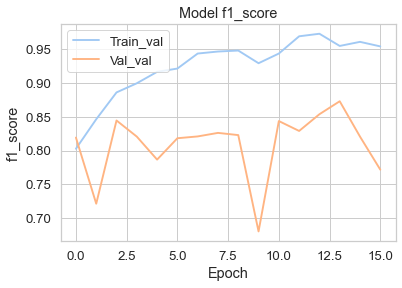

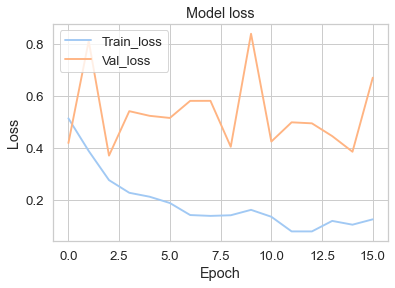

[INFO]: Saving plots.............. OK 


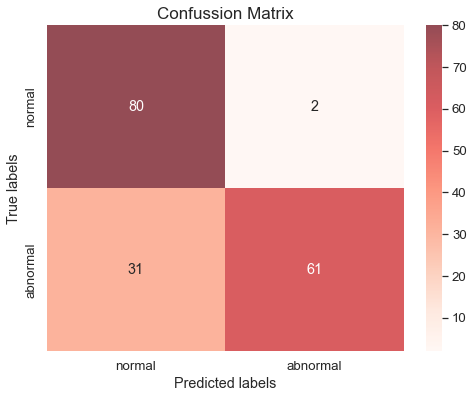

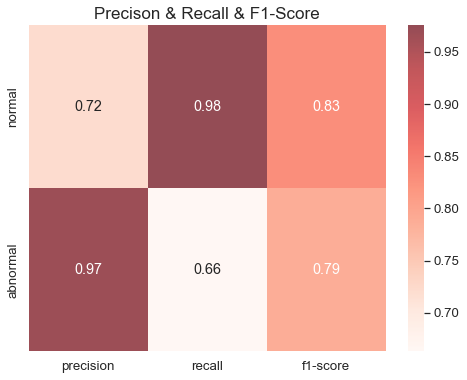

[INFO]: Saving confusion matrix and other metrics............OK
[INFO]: Saving model.............OK


In [129]:
model_2 = train_evaluate_model(model_2, 1, 0, BEST_BATCH)

### 3) Modelo 3: EfficientNet B0
#### Descongelamos todas las capas a partir del modelo anterior.

In [118]:
model_load_path_2 = models_list_path[1]+ SAVE_MODEL_PATH + MODEL_FILETYPE
model_3 = load_model(model_load_path_2)
model_3.trainable = True
model_3.summary()

Model: "EfficientNetB0_G"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 avg_pool (GlobalAveragePool  (None, 1280)             0         
 ing2D)                                                          
                                                                 
 batch_norm (BatchNormalizat  (None, 1280)             5120      
 ion)                                                            
                                                                 
 top_dropout (Dropout)       (None, 1280)              0         
                                                                 
 activationLayer (Dense)     (None, 2)            

In [119]:
callbacks = model_callbacks(
    models_list_path[2], reduceLr=False,
    checkPoint=True, csvlogger=True,
    earlyStopping=True, progbar=False,
    remotemonitor=False, tensorboard=False)

print('[INFO]: Callbacks Activate: ', callbacks)

[INFO]: Callbacks Activate:  [<keras.callbacks.ModelCheckpoint object at 0x000001845475A020>, <keras.callbacks.CSVLogger object at 0x0000018454758430>, <keras.callbacks.EarlyStopping object at 0x00000183E109E380>]


[INFO]: Data argumentation & Image Generator] : Fold number: 0, Shape:(224, 224, 3), Image Size:(224, 224)
Found 1379 images belonging to 2 classes.
[INFO]: Training Data Generator:...............OK
Found 154 images belonging to 2 classes.
[INFO]: Validation Data Generator:...............OK
Found 174 images belonging to 2 classes.
[INFO]: Test Data Generator:...............OK
INFO:tensorflow:Assets written to: models\model_3\assets
INFO:tensorflow:Assets written to: models\model_3\assets
INFO:tensorflow:Assets written to: models\model_3\assets
Epoch 16: early stopping
[INFO]: Model training ............... OK
[INFO]: Execution time:  236.85105659998953
6/6 [==============================] - 0s 41ms/step - loss: 0.5914 - f1_score: 0.8442
[INFO]: Model evaluating....loss: 0.5913786292076111, F1 score: 0.8442049026489258....OK


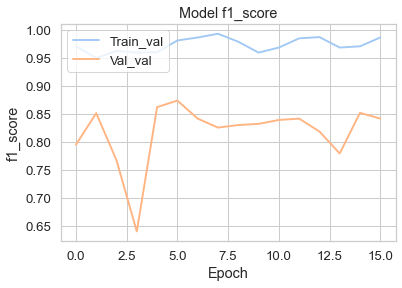

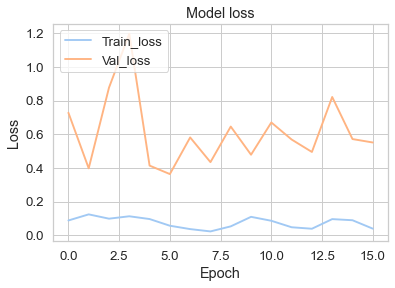

[INFO]: Saving plots.............. OK 


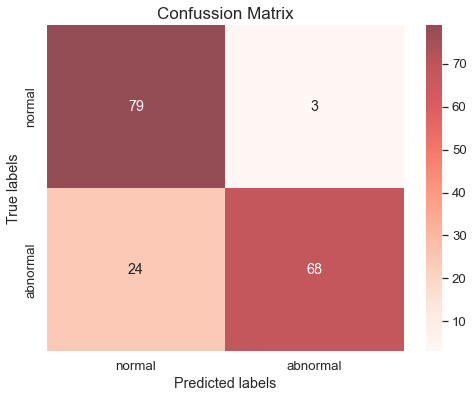

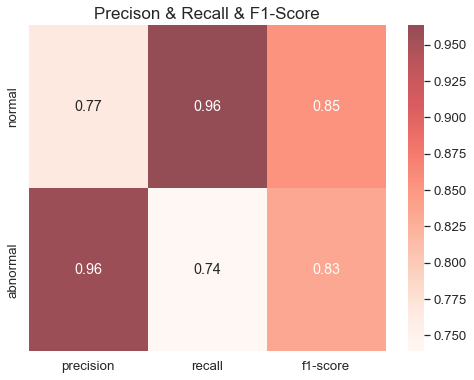

[INFO]: Saving confusion matrix and other metrics............OK
[INFO]: Saving model.............OK


In [120]:
train_evaluate_model(model_3, 2, 0, BEST_BATCH)

### 3) Modelo 4: VGG16
Creamos un nuevo modelo usando la aplicación de Keras VGG16. Utilizaremos los mismos parámetros que en los modelos anteriores para poder comparar las dos redes neuronales. Además como anteriormente utilizaremos el callback Early Stopping.

In [130]:
callbacks = model_callbacks(
    models_list_path[3], reduceLr=False,
    checkPoint=True, csvlogger=True,
    earlyStopping=True, progbar=False,
    remotemonitor=False, tensorboard=False )

print('[INFO]: Callbacks Activate: ', callbacks)

[INFO]: Callbacks Activate:  [<keras.callbacks.ModelCheckpoint object at 0x00000184968FAC50>, <keras.callbacks.CSVLogger object at 0x00000184968FB5E0>, <keras.callbacks.EarlyStopping object at 0x00000184968FB0D0>]


In [131]:
model_4 = model_vgg16(N_CLASSES, SHAPE, EPOCHS)
model_4.summary()

Model: "vgg16_Gloucoma"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 avg_pool (GlobalAveragePool  (None, 512)              0         
 ing2D)                                                          
                                                                 
 batch_norm (BatchNormalizat  (None, 512)              2048      
 ion)                                                            
                                                                 
 top_dropout (Dropout)       (None, 512)               0         
                                                                 
 activationLayer (Dense)     (None, 2)              

[INFO]: Data argumentation & Image Generator] : Fold number: 0, Shape:(224, 224, 3), Image Size:(224, 224)
Found 1379 images belonging to 2 classes.
[INFO]: Training Data Generator:...............OK
Found 154 images belonging to 2 classes.
[INFO]: Validation Data Generator:...............OK
Found 174 images belonging to 2 classes.
[INFO]: Test Data Generator:...............OK
INFO:tensorflow:Assets written to: models\model_4\assets
INFO:tensorflow:Assets written to: models\model_4\assets
INFO:tensorflow:Assets written to: models\model_4\assets
INFO:tensorflow:Assets written to: models\model_4\assets
Epoch 16: early stopping
[INFO]: Model training ............... OK
[INFO]: Execution time:  188.69094579998637
6/6 [==============================] - 1s 195ms/step - loss: 0.4556 - f1_score: 0.8174
[INFO]: Model evaluating....loss: 0.45560017228126526, F1 score: 0.8174433708190918....OK


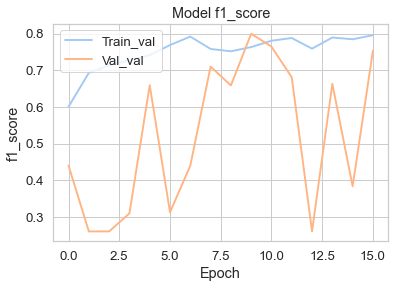

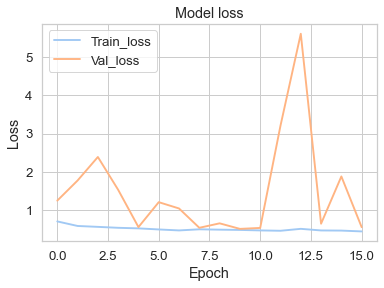

[INFO]: Saving plots.............. OK 


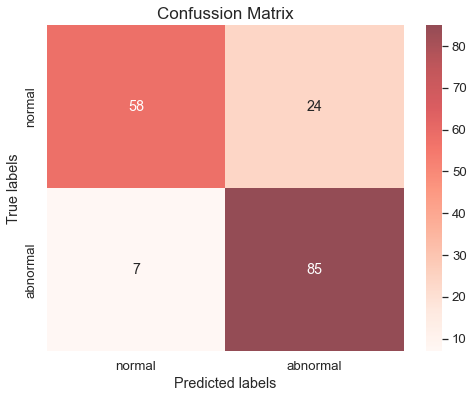

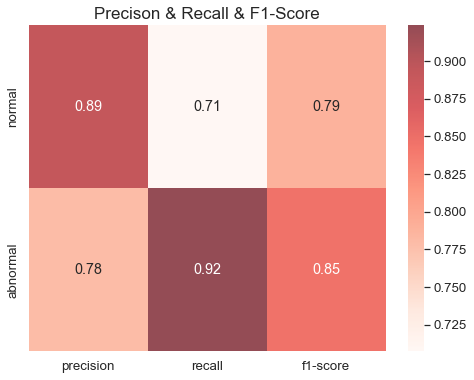

[INFO]: Saving confusion matrix and other metrics............OK
[INFO]: Saving model.............OK


In [132]:
train_evaluate_model(model_4, 3, 0, BEST_BATCH)

Este modelo obtiene uin F1 - Score menor que el modelo 3, por lo que lo descartaremos.

### 4) Modelo 5: EfficientNetB2
Para este modelo utilizaremos una red neuronal EffcientNet, pero en este caso la EfficientNetB2. Por otro lado, Utilizaremos una técnica diferente, fijaremos un EPOCHS de 100 y en este caso utilizaremos un callback de reduce lr y no el de EarlyStopping.

In [133]:
model_5 = model_EfficientNetB2(N_CLASSES, SHAPE, EPOCHS)
model_5.summary()

Model: "EfficientNetB2_Gloucoma"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb2 (Functional)  (None, None, None, 1408)  7768569  
                                                                 
 avg_pool (GlobalAveragePool  (None, 1408)             0         
 ing2D)                                                          
                                                                 
 batch_norm (BatchNormalizat  (None, 1408)             5632      
 ion)                                                            
                                                                 
 top_dropout (Dropout)       (None, 1408)              0         
                                                                 
 activationLayer (Dense)     (None, 2)     

In [134]:
callbacks = model_callbacks(
    models_list_path[3], reduceLr=True,
    checkPoint=True, csvlogger=True,
    earlyStopping=False, progbar=False,
    remotemonitor=False, tensorboard=False )

print('[INFO]: Callbacks Activate: ', callbacks)

[INFO]: Callbacks Activate:  [<keras.callbacks.ReduceLROnPlateau object at 0x00000184D60FBD30>, <keras.callbacks.ModelCheckpoint object at 0x00000184D60F89D0>, <keras.callbacks.CSVLogger object at 0x00000184D60F8640>]


[INFO]: Data argumentation & Image Generator] : Fold number: 0, Shape:(224, 224, 3), Image Size:(224, 224)
Found 1379 images belonging to 2 classes.
[INFO]: Training Data Generator:...............OK
Found 154 images belonging to 2 classes.
[INFO]: Validation Data Generator:...............OK
Found 174 images belonging to 2 classes.
[INFO]: Test Data Generator:...............OK
INFO:tensorflow:Assets written to: models\model_4\assets
INFO:tensorflow:Assets written to: models\model_4\assets
INFO:tensorflow:Assets written to: models\model_4\assets
INFO:tensorflow:Assets written to: models\model_4\assets
INFO:tensorflow:Assets written to: models\model_4\assets
INFO:tensorflow:Assets written to: models\model_4\assets
INFO:tensorflow:Assets written to: models\model_4\assets
[INFO]: Model training ............... OK
[INFO]: Execution time:  1730.4375399999553
6/6 [==============================] - 1s 174ms/step - loss: 0.3240 - f1_score: 0.9195
[INFO]: Model evaluating....loss: 0.3239977657794

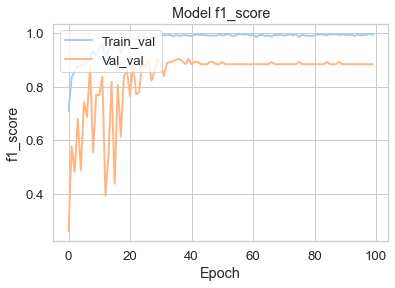

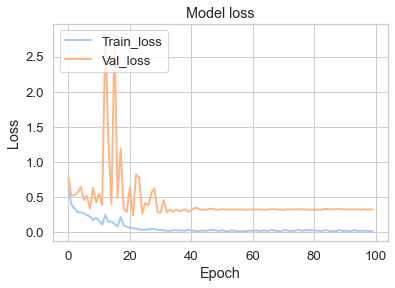

[INFO]: Saving plots.............. OK 


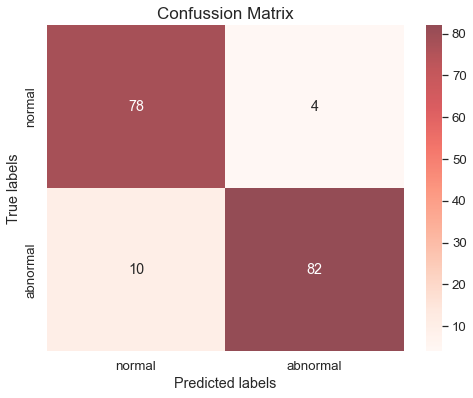

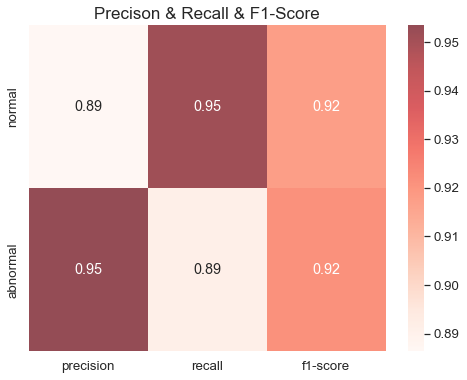

[INFO]: Saving confusion matrix and other metrics............OK
[INFO]: Saving model.............OK


In [135]:
train_evaluate_model(model_5, 4, 0, BEST_BATCH)

Apenas hay diferencia con el resultado del modelo 3, además el proceso de ejecución es mucho más largo en este modelo.

## Sección 3. Validación Cruza y discusión

Para realizar este nálisis fibnal utilizaremos el último modelo ya que es en él es el que mejor resultados os ofrece. Crearemos en el directorio del modelo final 10 carpetas donde guardaremos los distintos modelos entrados para cada fold, sus pesos, parámetros, resultados, etc

In [136]:
models_by_fold_list_path = create_final_model_directories(models_list_path[5])

In [137]:
callbacks = model_callbacks(
models_by_fold_list_path[0], reduceLr=False,
checkPoint=False, csvlogger=False,
earlyStopping=True, progbar=False,
remotemonitor=False, tensorboard=False )

In [138]:
models_list_path = models_by_fold_list_path

[INFO] : Final Model Fold number: 0 is training and Evaluating
[INFO]: Data argumentation & Image Generator] : Fold number: 0, Shape:(224, 224, 3), Image Size:(224, 224)
Found 1379 images belonging to 2 classes.
[INFO]: Training Data Generator:...............OK
Found 154 images belonging to 2 classes.
[INFO]: Validation Data Generator:...............OK
Found 174 images belonging to 2 classes.
[INFO]: Test Data Generator:...............OK
Epoch 16: early stopping
[INFO]: Model training ............... OK
[INFO]: Execution time:  175.9146617000224
6/6 [==============================] - 0s 43ms/step - loss: 0.4286 - f1_score: 0.8678
[INFO]: Model evaluating....loss: 0.4286480247974396, F1 score: 0.8677768111228943....OK


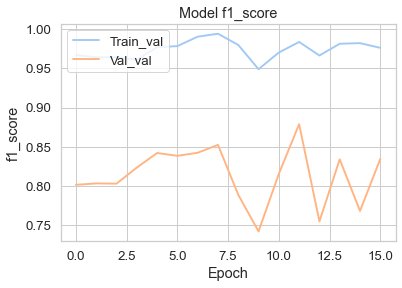

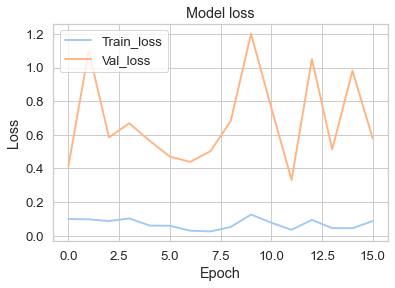

[INFO]: Saving plots.............. OK 


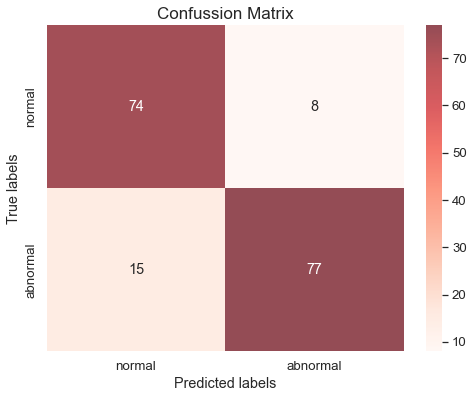

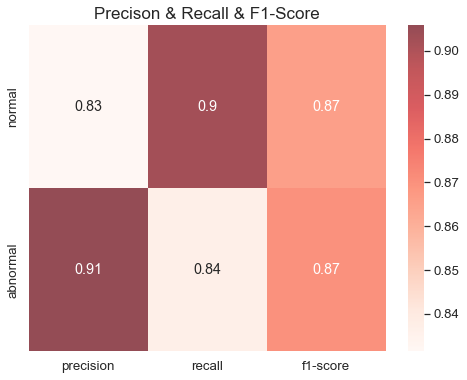

[INFO]: Saving confusion matrix and other metrics............OK
[INFO]: Saving model.............OK
[INFO] : Final Model Fold number: 0 training and Evaluating ..... OK 
[INFO] : Final Model Fold number: 1 is training and Evaluating
[INFO]: Data argumentation & Image Generator] : Fold number: 1, Shape:(224, 224, 3), Image Size:(224, 224)
Found 1379 images belonging to 2 classes.
[INFO]: Training Data Generator:...............OK
Found 154 images belonging to 2 classes.
[INFO]: Validation Data Generator:...............OK
Found 174 images belonging to 2 classes.
[INFO]: Test Data Generator:...............OK
Epoch 16: early stopping
[INFO]: Model training ............... OK
[INFO]: Execution time:  182.35978090000572
6/6 [==============================] - 1s 111ms/step - loss: 0.0865 - f1_score: 0.9770
[INFO]: Model evaluating....loss: 0.08654278516769409, F1 score: 0.9769628047943115....OK


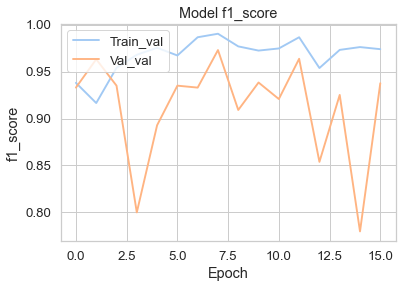

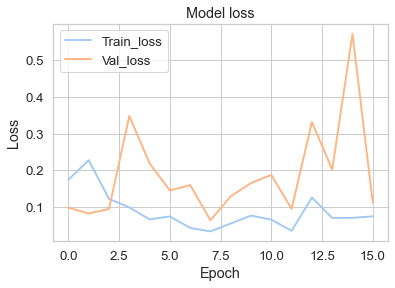

[INFO]: Saving plots.............. OK 


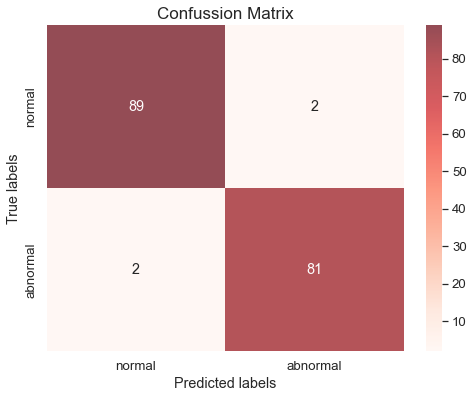

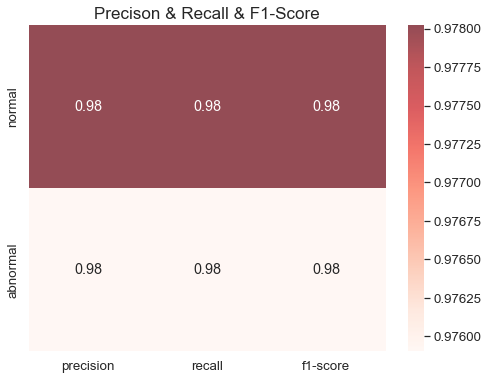

[INFO]: Saving confusion matrix and other metrics............OK
[INFO]: Saving model.............OK
[INFO] : Final Model Fold number: 1 training and Evaluating ..... OK 
[INFO] : Final Model Fold number: 2 is training and Evaluating
[INFO]: Data argumentation & Image Generator] : Fold number: 2, Shape:(224, 224, 3), Image Size:(224, 224)
Found 1379 images belonging to 2 classes.
[INFO]: Training Data Generator:...............OK
Found 154 images belonging to 2 classes.
[INFO]: Validation Data Generator:...............OK
Found 174 images belonging to 2 classes.
[INFO]: Test Data Generator:...............OK
Epoch 16: early stopping
[INFO]: Model training ............... OK
[INFO]: Execution time:  181.23333660000935
6/6 [==============================] - 1s 121ms/step - loss: 0.2895 - f1_score: 0.9056
[INFO]: Model evaluating....loss: 0.2895427644252777, F1 score: 0.9056015610694885....OK


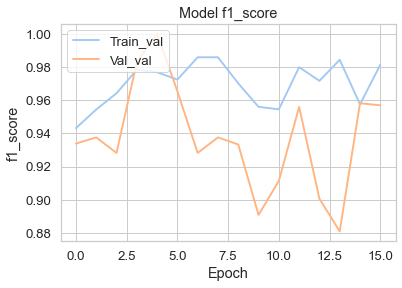

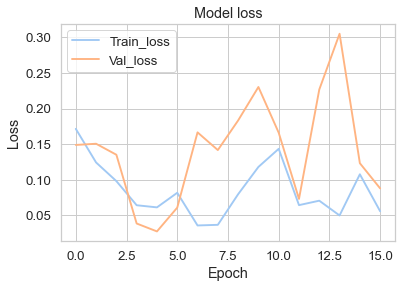

[INFO]: Saving plots.............. OK 


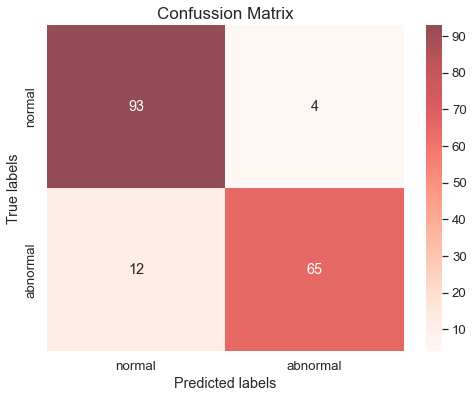

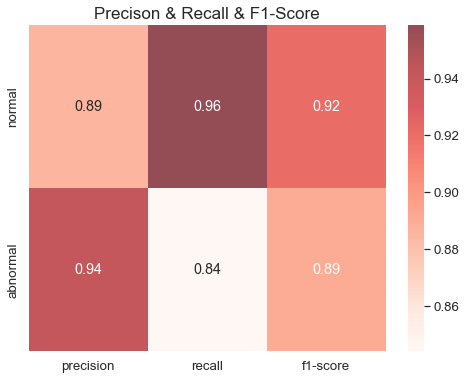

[INFO]: Saving confusion matrix and other metrics............OK
[INFO]: Saving model.............OK
[INFO] : Final Model Fold number: 2 training and Evaluating ..... OK 
[INFO] : Final Model Fold number: 3 is training and Evaluating
[INFO]: Data argumentation & Image Generator] : Fold number: 3, Shape:(224, 224, 3), Image Size:(224, 224)
Found 1379 images belonging to 2 classes.
[INFO]: Training Data Generator:...............OK
Found 154 images belonging to 2 classes.
[INFO]: Validation Data Generator:...............OK
Found 174 images belonging to 2 classes.
[INFO]: Test Data Generator:...............OK
Epoch 16: early stopping
[INFO]: Model training ............... OK
[INFO]: Execution time:  178.30063810001593
6/6 [==============================] - 1s 111ms/step - loss: 0.2627 - f1_score: 0.9189
[INFO]: Model evaluating....loss: 0.26266276836395264, F1 score: 0.9188541173934937....OK


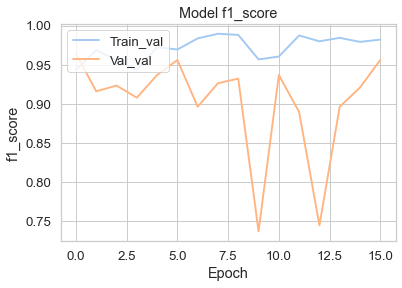

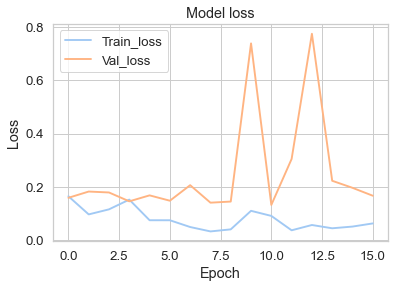

[INFO]: Saving plots.............. OK 


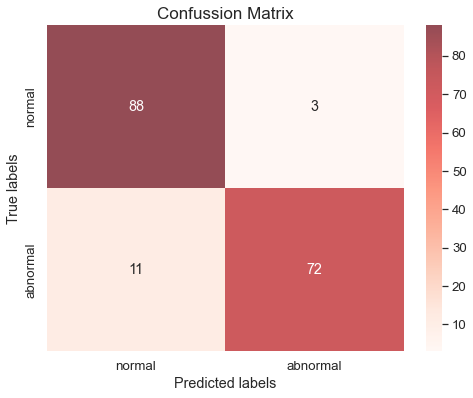

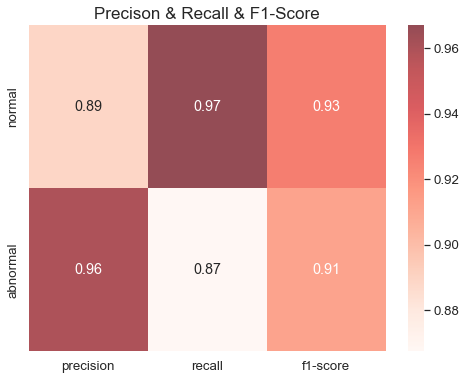

[INFO]: Saving confusion matrix and other metrics............OK
[INFO]: Saving model.............OK
[INFO] : Final Model Fold number: 3 training and Evaluating ..... OK 
[INFO] : Final Model Fold number: 4 is training and Evaluating
[INFO]: Data argumentation & Image Generator] : Fold number: 4, Shape:(224, 224, 3), Image Size:(224, 224)
Found 1379 images belonging to 2 classes.
[INFO]: Training Data Generator:...............OK
Found 154 images belonging to 2 classes.
[INFO]: Validation Data Generator:...............OK
Found 174 images belonging to 2 classes.
[INFO]: Test Data Generator:...............OK
Epoch 16: early stopping
[INFO]: Model training ............... OK
[INFO]: Execution time:  179.07837989996187
6/6 [==============================] - 1s 109ms/step - loss: 0.3388 - f1_score: 0.9063
[INFO]: Model evaluating....loss: 0.3387920558452606, F1 score: 0.9062626361846924....OK


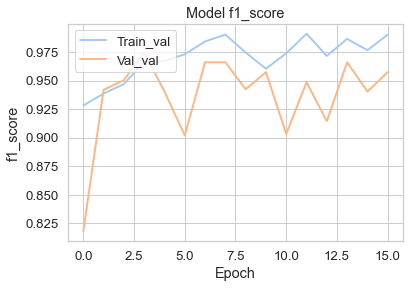

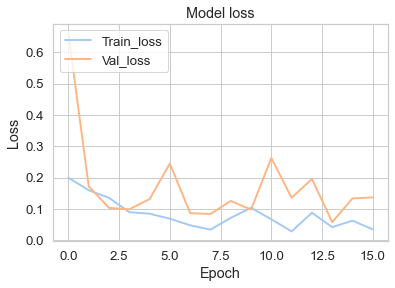

[INFO]: Saving plots.............. OK 


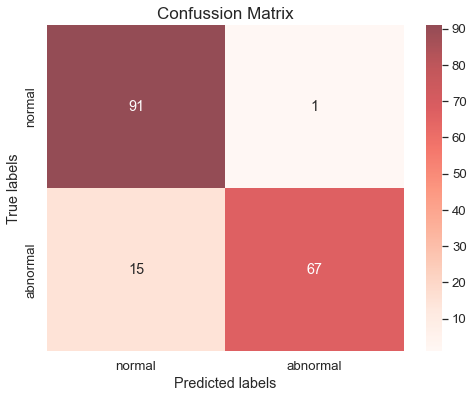

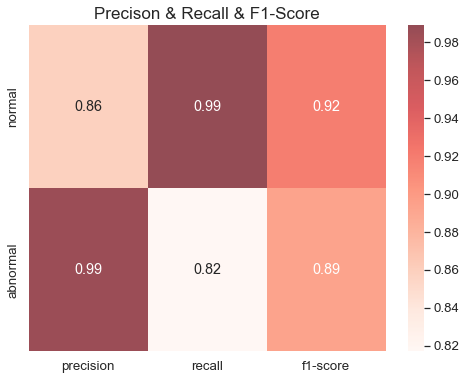

[INFO]: Saving confusion matrix and other metrics............OK
[INFO]: Saving model.............OK
[INFO] : Final Model Fold number: 4 training and Evaluating ..... OK 
[INFO] : Final Model Fold number: 5 is training and Evaluating
[INFO]: Data argumentation & Image Generator] : Fold number: 5, Shape:(224, 224, 3), Image Size:(224, 224)
Found 1379 images belonging to 2 classes.
[INFO]: Training Data Generator:...............OK
Found 154 images belonging to 2 classes.
[INFO]: Validation Data Generator:...............OK
Found 174 images belonging to 2 classes.
[INFO]: Test Data Generator:...............OK
Epoch 16: early stopping
[INFO]: Model training ............... OK
[INFO]: Execution time:  172.8485897000064
6/6 [==============================] - 1s 110ms/step - loss: 0.5780 - f1_score: 0.8143
[INFO]: Model evaluating....loss: 0.5780372023582458, F1 score: 0.8143265247344971....OK


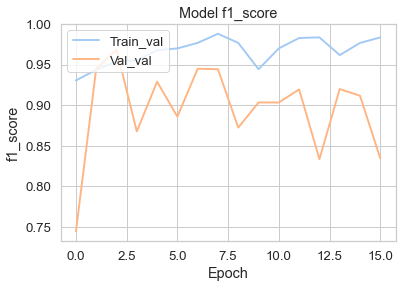

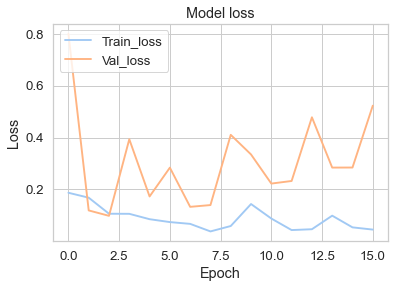

[INFO]: Saving plots.............. OK 


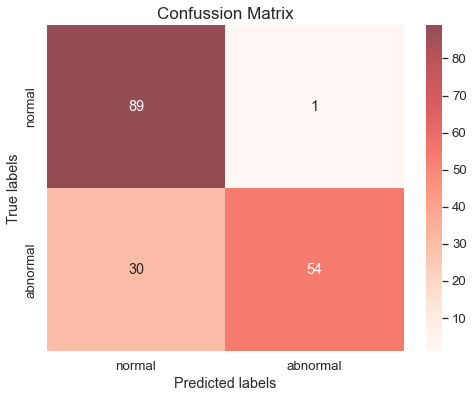

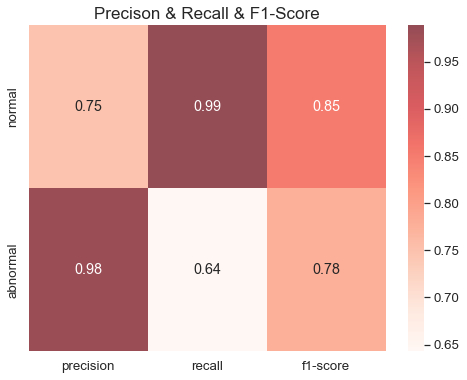

[INFO]: Saving confusion matrix and other metrics............OK
[INFO]: Saving model.............OK
[INFO] : Final Model Fold number: 5 training and Evaluating ..... OK 
[INFO] : Final Model Fold number: 6 is training and Evaluating
[INFO]: Data argumentation & Image Generator] : Fold number: 6, Shape:(224, 224, 3), Image Size:(224, 224)
Found 1379 images belonging to 2 classes.
[INFO]: Training Data Generator:...............OK
Found 154 images belonging to 2 classes.
[INFO]: Validation Data Generator:...............OK
Found 174 images belonging to 2 classes.
[INFO]: Test Data Generator:...............OK
Epoch 16: early stopping
[INFO]: Model training ............... OK
[INFO]: Execution time:  173.64212229999248
6/6 [==============================] - 0s 41ms/step - loss: 0.2678 - f1_score: 0.8850
[INFO]: Model evaluating....loss: 0.26779982447624207, F1 score: 0.8849967122077942....OK


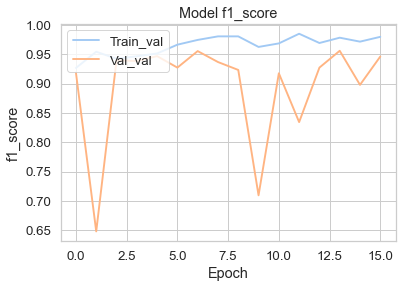

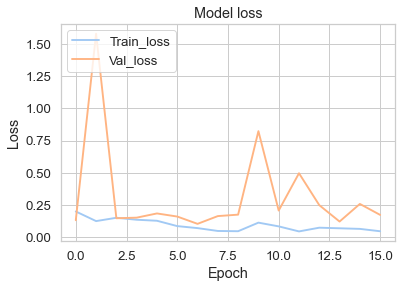

[INFO]: Saving plots.............. OK 


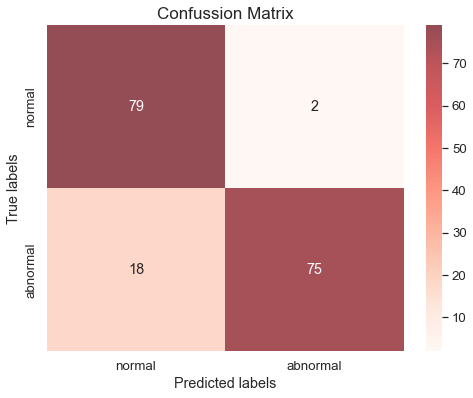

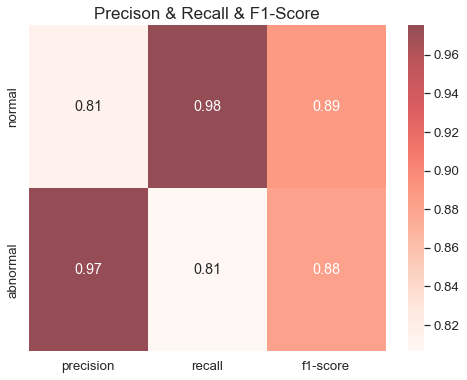

[INFO]: Saving confusion matrix and other metrics............OK
[INFO]: Saving model.............OK
[INFO] : Final Model Fold number: 6 training and Evaluating ..... OK 
[INFO] : Final Model Fold number: 7 is training and Evaluating
[INFO]: Data argumentation & Image Generator] : Fold number: 7, Shape:(224, 224, 3), Image Size:(224, 224)
Found 1379 images belonging to 2 classes.
[INFO]: Training Data Generator:...............OK
Found 154 images belonging to 2 classes.
[INFO]: Validation Data Generator:...............OK
Found 174 images belonging to 2 classes.
[INFO]: Test Data Generator:...............OK
Epoch 16: early stopping
[INFO]: Model training ............... OK
[INFO]: Execution time:  172.01490850001574
6/6 [==============================] - 0s 42ms/step - loss: 0.3136 - f1_score: 0.9092
[INFO]: Model evaluating....loss: 0.31360727548599243, F1 score: 0.9092332124710083....OK


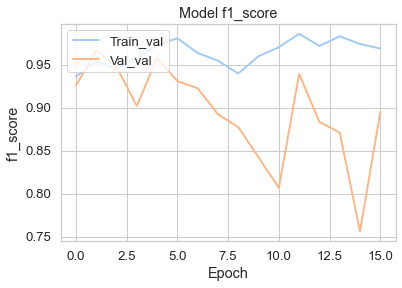

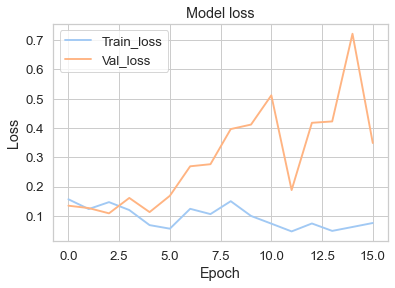

[INFO]: Saving plots.............. OK 


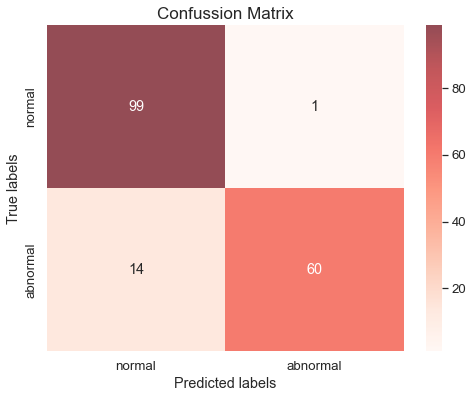

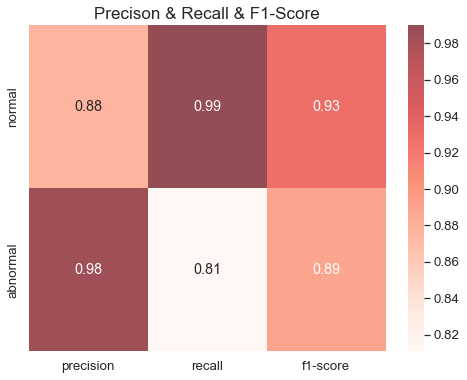

[INFO]: Saving confusion matrix and other metrics............OK
[INFO]: Saving model.............OK
[INFO] : Final Model Fold number: 7 training and Evaluating ..... OK 
[INFO] : Final Model Fold number: 8 is training and Evaluating
[INFO]: Data argumentation & Image Generator] : Fold number: 8, Shape:(224, 224, 3), Image Size:(224, 224)
Found 1379 images belonging to 2 classes.
[INFO]: Training Data Generator:...............OK
Found 154 images belonging to 2 classes.
[INFO]: Validation Data Generator:...............OK
Found 174 images belonging to 2 classes.
[INFO]: Test Data Generator:...............OK
Epoch 16: early stopping
[INFO]: Model training ............... OK
[INFO]: Execution time:  170.02462829998694
6/6 [==============================] - 0s 46ms/step - loss: 0.4537 - f1_score: 0.8160
[INFO]: Model evaluating....loss: 0.4536729156970978, F1 score: 0.8159986734390259....OK


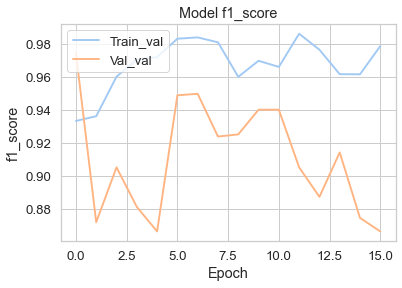

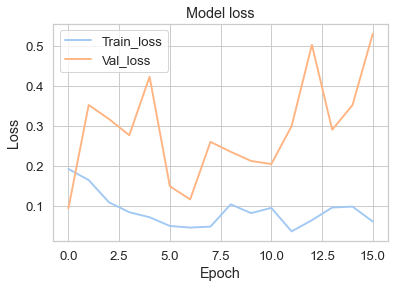

[INFO]: Saving plots.............. OK 


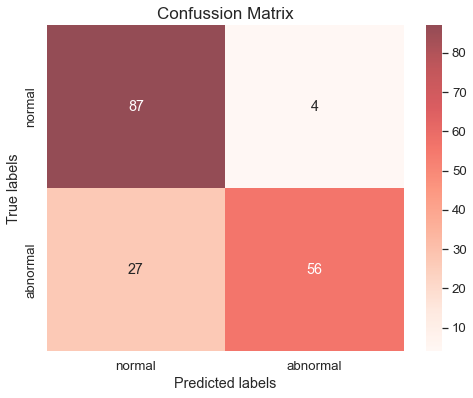

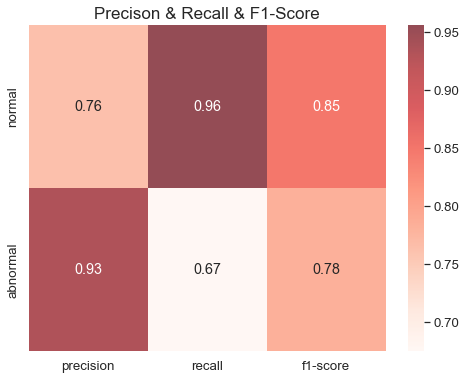

[INFO]: Saving confusion matrix and other metrics............OK
[INFO]: Saving model.............OK
[INFO] : Final Model Fold number: 8 training and Evaluating ..... OK 
[INFO] : Final Model Fold number: 9 is training and Evaluating
[INFO]: Data argumentation & Image Generator] : Fold number: 9, Shape:(224, 224, 3), Image Size:(224, 224)
Found 1379 images belonging to 2 classes.
[INFO]: Training Data Generator:...............OK
Found 154 images belonging to 2 classes.
[INFO]: Validation Data Generator:...............OK
Found 174 images belonging to 2 classes.
[INFO]: Test Data Generator:...............OK
Epoch 16: early stopping
[INFO]: Model training ............... OK
[INFO]: Execution time:  168.02246070001274
6/6 [==============================] - 0s 41ms/step - loss: 0.2410 - f1_score: 0.9272
[INFO]: Model evaluating....loss: 0.2410486787557602, F1 score: 0.9271865487098694....OK


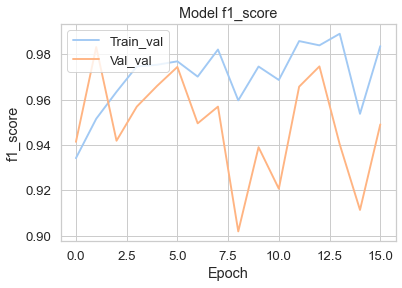

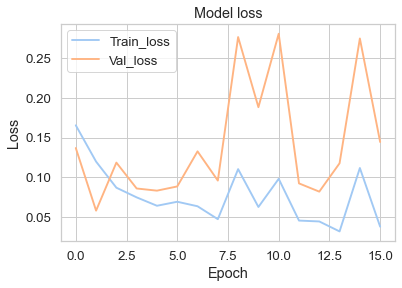

[INFO]: Saving plots.............. OK 


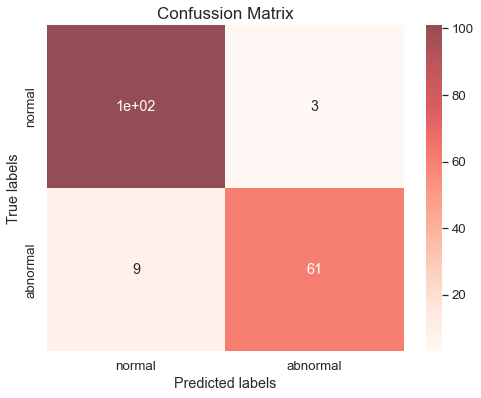

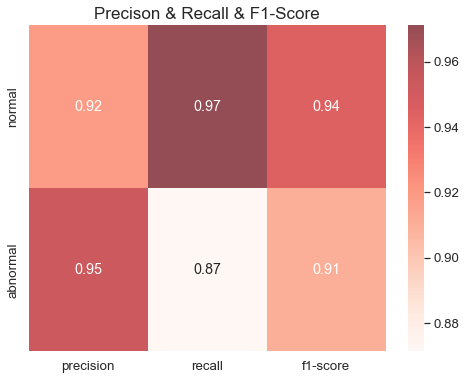

[INFO]: Saving confusion matrix and other metrics............OK
[INFO]: Saving model.............OK
[INFO] : Final Model Fold number: 9 training and Evaluating ..... OK 


In [139]:
for fold in range(0, N_FOLDS):
    print(
        f'[INFO] : Final Model Fold number: {fold} is training and Evaluating')
    
    model_final = load_model(model_load_path_2)
    model_final.trainable = True
    
    train_evaluate_model(model_final, fold, fold, BEST_BATCH)
    print(
        f'[INFO] : Final Model Fold number: {fold} training and Evaluating ..... OK ')

## Estadísticas finales

Guardamos las métricas de cada fold en un dataframe:

In [140]:
data_info_final_models = {'Fold_name': [], 'Loss': [], 'F1_Score': []}

for fold in range(0, N_FOLDS):
    train_generator, validation_generator, test_generator = build_image_generator(
        fold)
    model_load_path = models_by_fold_list_path[fold] + \
        SAVE_MODEL_PATH + MODEL_FILETYPE
    new_model = load_model(model_load_path)
    loss, F1_score = new_model.evaluate(test_generator, verbose=2)

    data_info_final_models['Fold_name'].append(fold)
    data_info_final_models['Loss'].append(loss)
    data_info_final_models['F1_Score'].append(F1_score)
    print(
        f'[INFO] : Fold number: {fold} has been evaluated and metrics has been saved')

final_metrics_df = pd.DataFrame(data_info_final_models)

[INFO]: Data argumentation & Image Generator] : Fold number: 0, Shape:(224, 224, 3), Image Size:(224, 224)
Found 1379 images belonging to 2 classes.
[INFO]: Training Data Generator:...............OK
Found 154 images belonging to 2 classes.
[INFO]: Validation Data Generator:...............OK
Found 174 images belonging to 2 classes.
[INFO]: Test Data Generator:...............OK
6/6 - 2s - loss: 0.4286 - f1_score: 0.8678 - 2s/epoch - 271ms/step
[INFO] : Fold number: 0 has been evaluated and metrics has been saved
[INFO]: Data argumentation & Image Generator] : Fold number: 1, Shape:(224, 224, 3), Image Size:(224, 224)
Found 1379 images belonging to 2 classes.
[INFO]: Training Data Generator:...............OK
Found 154 images belonging to 2 classes.
[INFO]: Validation Data Generator:...............OK
Found 174 images belonging to 2 classes.
[INFO]: Test Data Generator:...............OK
6/6 - 1s - loss: 0.0865 - f1_score: 0.9770 - 1s/epoch - 236ms/step
[INFO] : Fold number: 1 has been evalu

Guardamos las métricas de la evaluación de los distintos folds:

In [141]:
save_metrics_path = MODEL_PATH + MODEL_FINAL_NAME + CSV_FINAL_NAME
final_metrics_df.to_csv(save_metrics_path)
print('[INFO]: Final model metrics has been saved: \n')
display(final_metrics_df)
print('[INFO]: Final model stadistics: \n', final_metrics_df.describe())

[INFO]: Final model metrics has been saved: 



,Fold_name,Loss,F1_Score
0,0,0.428648,0.867777
1,1,0.086543,0.976963
2,2,0.289543,0.905602
3,3,0.262663,0.918854
4,4,0.338792,0.906263
5,5,0.578037,0.814327
6,6,0.267800,0.884997
7,7,0.313607,0.909233
8,8,0.453673,0.815999
9,9,0.241049,0.927187


[INFO]: Final model stadistics: 
        Fold_name       Loss   F1_Score
count   10.00000  10.000000  10.000000
mean     4.50000   0.326035   0.892720
std      3.02765   0.134974   0.049781
min      0.00000   0.086543   0.814327
25%      2.25000   0.263947   0.872082
50%      4.50000   0.301575   0.905932
75%      6.75000   0.406184   0.916449
max      9.00000   0.578037   0.976963


Representamos y Guardamos las representaciones gráficas de la evaluación de los distintos folds:

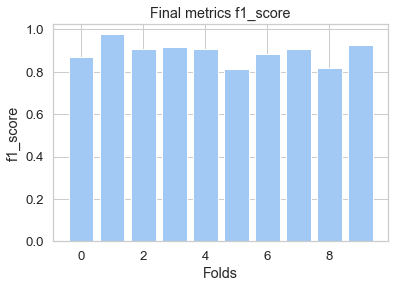

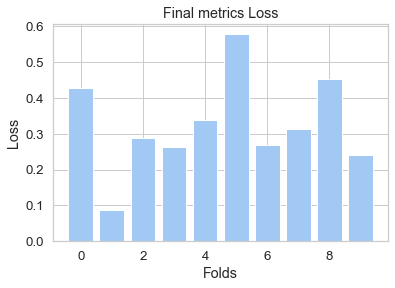

In [143]:
fig, ax = plt.subplots()
ax.bar(final_metrics_df['Fold_name'], final_metrics_df['F1_Score'])
plt.title('Final metrics f1_score')
plt.ylabel('f1_score')
plt.xlabel('Folds')
plt.savefig(os.path.join(MODEL_PATH + MODEL_FINAL_NAME,
            '1_.Final_Metrics_f1_score.png'))
plt.show()

plt.bar(final_metrics_df['Fold_name'], final_metrics_df['Loss'])
plt.title('Final metrics Loss')
plt.ylabel('Loss')
plt.xlabel('Folds')
plt.savefig(os.path.join(MODEL_PATH + MODEL_FINAL_NAME,
            '21_.Final_Metrics_Loss_score.png'))
plt.show()

Como he comentado en el informe, el objetivo de nuestros futuros trabajos debe centrarse en  intentar seguir reduciendo los falsos negativos, los modelos obtenidos al parecer tienden a clasificar peor ciertos tipos de pacientes con glaucoma, debemos estudiar dichas imágenes y establecer ciertos parámetros que tengan en común. 

Por otro lado, podríamos usar técnicas de combinación de clasificadores, en concreto podríamos utilizar técnicas de boosting o combinaciones secuenciales de clasificadores bases muy diferentes, ya que es conocido por los especialistas del glaucoma que hay ciertos pacientes con características concretas más propensos a sufrir esta enfermedad. Por ello podríamos encontrar ciertas formas de combinar las imágenes y ciertos datos médicos. 

### Bonus : Prototipo de webApp para la detención del Gloucoma:

In [235]:
best_model_load_path = 'models/model_final/Results_Fold_1/saved_model.h5'
new_model = load_model(model_load_path)

In [236]:
import gradio as gr
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import PIL
import pathlib

In [237]:
def predict_input_image(img):
    img_4d=img.reshape(-1,224,224,3)
    prediction=new_model.predict(img_4d)[0]
    return {CLASS_NAMES[i]: float(prediction[i]) for i in range(2)}

In [238]:
image = gr.inputs.Image(shape=(224,224))
label = gr.outputs.Label(num_top_classes=2)

C:\Users\Jorge\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Users\Jorge\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Podemos elegir cualquier imagen de los conjuntos de test y probar cómo funciona nuestro prototipo.

In [ ]:
gr.Interface(fn=predict_input_image, inputs=image, outputs=label,interpretation='default',
            title = 'Clasificador Neuronal para la detección del glaucoma',
            ).launch(debug='True', share = True)

Running on local URL:  http://127.0.0.1:7860/
Running on public URL: https://59527.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


## Sección 4. Análisis crítico

A)	

    1) En este caso, la estrategia me parece adecuada ya que gracias a la API de keras podemos cargar las imágenes con facilidad, además plantearlo de este modo nos permite en un último momento, verificar aquellos mejores modelos con cross validation.  Por otro lado, permite guardar los modelos por cada Fold y poder realizar la ejecución del modelo en pasos más pequeños.
    
    2) Algunos puntos importantes en el diseño de estas particiones serán los siguientes:
        •	Estos datos deber ser diferentes a los del conjunto de test.
        •	Tanto para el conjunto de datos entrenamiento como el de validación será importante que tengan el mismo número de imágenes para cada Fold.
        •	La media total de la métrica de los distintos folds es importante pero lo es más la desviación típica ya que debemos encontrar modelos consistentes y generalistas. 
        

B)	Tras realizar la práctica he llegado a varias conclusiones, que expongo a continuación:
        
        a.	Tanto Data generator como data argumentation son muy útiles en modelos de clasificación de imágenes, gracias a estas herramientas podemos realizar pequeñas transformaciones en imágenes fácilmente, así como cargar los distintos conjuntos de entrenamiento, validación y test, por directorios clasificados según sus clases.
        
        b.	Debemos tener cuidado a cargar estas imágenes ya que dependiendo del orden de las carpetas la api de keras nos podrá asociar por error las clases, para evitarlo debemos indicarle que clase corresponderá a 0 o 1.  
        
        c.	El optimizar Adam es muy eficiente junto a learining rates bajos que oscilan entre 0.0001 y 0.001. Y se pueden combinar con valores de 32 o 64 batchs.
        
        d.	La función softmax también funciona correctamente ante clasificadores binarios.
        
        e.	La capa dropout permite contener el overffiting. 
        
        f.	Las dimensiones de las imágenes influyen en la eficiencia del modelo, pero a veces si no lo reducimos no permite trabajar con modelos más profundos y con mayor cantidad de parámetros. 
        
        g.	Aparentemente un modelo puede funcionar muy bien ante una evaluación después del entrenamiento y test pero puede ser inestable ante el cross validation, en ese caso debemos elegir el que mejor generalice. 
        
        h. Siempre que podamos será conveniente utilizar técnicas de transfer learning.


------------------------------------------------------------------------------------------------------------------------------